#EOF analysis of dissolved Barium & analysis of modes

In [1]:
import sys
sys.path.insert(0, '../../_libs/')
import NEMO_tools as Nts
import Atmos_tools as Ats

In [43]:
reload(Ats)

<module 'Atmos_tools' from '../../_libs/Atmos_tools.py'>

In [253]:
import glob
import datetime
import scipy.io
import numpy as np
import seaborn as sb
import netCDF4 as nc
import matplotlib.pyplot as plt
from scipy.signal import detrend
from scipy.stats.stats import pearsonr
from NEMO_tools import reporj_NEMOgrid
from mpl_toolkits.basemap import Basemap, cm
% matplotlib inline

In [129]:
sb.set_style('white')

In [3]:
RB=[0.25, 0.41, 0.88]    # Royal blue
AM=[0.90, 0.17, 0.31]    # Amathran

In [4]:
from dateutil.relativedelta import relativedelta
base = datetime.datetime(2002, 1, 1)
date_list = [base + relativedelta(months=x) for x in range(144)]

In [46]:
coordinate_name=glob.glob('/ocean/yingkai/GEOTRACES/NEMO-CODE/NEMOGCM/CONFIG/ANHA4_OFF/EXP00/mesh_zgr.nc')
coordinate_obj=nc.Dataset(coordinate_name[0])
nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]
e1t = coordinate_obj.variables['e1t'][:]
e2t = coordinate_obj.variables['e2t'][:]
e3t = coordinate_obj.variables['e3t_0'][:]

# EOF with dtrend $\mathsf{Ba_d}$

In [6]:
FName = '/ocean/yingkai/GEOTRACES/Simulations/BASE01_1m_20020101_20131231_ptrc_T.nc'
ptrc_obj = nc.Dataset(FName)
Ba = ptrc_obj.variables['Ba'][:, :20, :, :]
Ba[Ba==0]=np.nan
Ba = np.nanmean(Ba, 1)

/home/yingkai/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [7]:
Ba_np = Ba[:, 350:, :]
#Ba_np_0 = np.copy(Ba_np)
#Ba_np_0[np.isnan(Ba_np_0)] = 0.0
#Ba_anom = seasonal_decomp3d(Ba_np_0)
#Ba_dtrend = detrend(Ba_np_0, 0)

In [10]:
MAT = scipy.io.loadmat('../../_data/Exchange/dtrend_Ba.mat')
Ba_dtrend = MAT['dtrend_Ba'][:]

In [11]:
Ba_dtrend_anom = Ats.seasonal_decomp3d(Ba_dtrend)
Ba_eof = np.transpose(Ba_dtrend_anom, [1, 2, 0])

In [12]:
EOFs, PC, expvar = Ats.EOF(Ba_eof, nmode=10, ndim=3, reverse=1)

../../_libs/Atmos_tools.py:277: ComplexWarning: Casting complex values to real discards the imaginary part
  eof[i, :] = np.squeeze(E[:, i]).T
../../_libs/Atmos_tools.py:278: ComplexWarning: Casting complex values to real discards the imaginary part
  PC[i, :]  = np.squeeze(Z[i, :])


## Expvar 

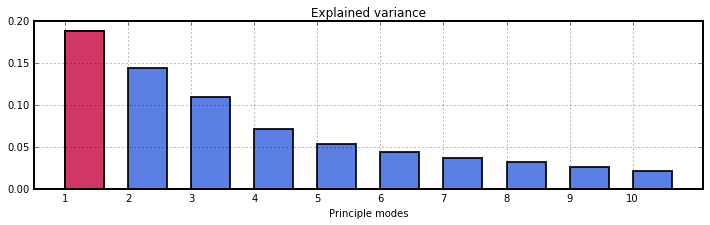

In [13]:
fig=plt.figure(figsize=(12, 3))
ax=plt.gca(); ax.grid(); ax.set_xlim(0.5, 11.118)
ax.bar(np.arange(1, 11), expvar, width=0.618, lw=2, alpha=0.85, color=RB)
ax.bar(1, expvar[0], width=0.618, lw=2, alpha=0.85, color=AM)
ax.set_xticks(np.arange(1, 11))
[i.set_linewidth(2) for i in ax.spines.itervalues()]
ax.set_xlabel('Principle modes')
ax.set_title('Explained variance', fontsize=12)

## Modes

In [111]:
def draw_smode(lon, lat, EOFs, clevs, num, ax):
    proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
    #proj.drawparallels(np.arange(59, 100, 10), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90, linewidth=0)
    proj.fillcontinents(color=[0.8, 0.8, 0.8], lake_color=None)
    proj.drawcoastlines(linewidth=0.5, color='k')
    x, y = proj(lon, lat)
    CS = proj.contourf(x, y, EOFs[:, :, num], clevs, cmap=plt.cm.RdBu_r, extend='both')
    #proj.contour(x, y, EOFs[:, :, num], clevs, colors='gray', linewidths=1.5)
    return CS

In [112]:
clevs = np.array([-5.5, -4.5, -3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5])*0.75

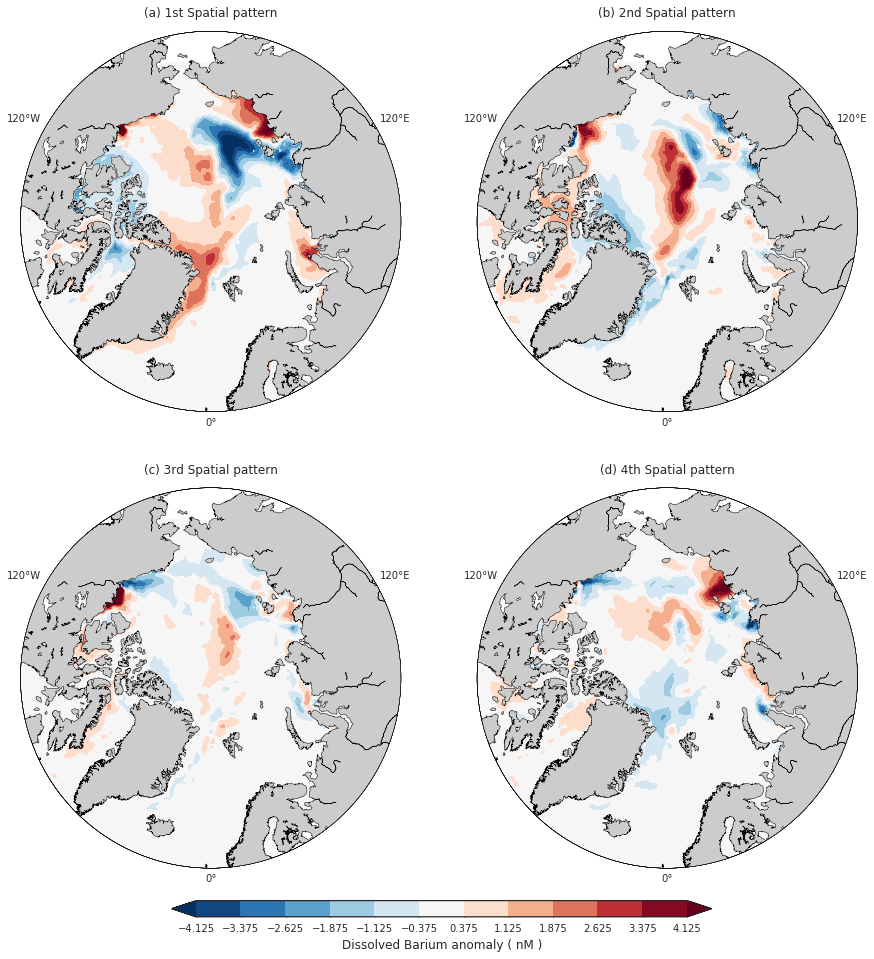

In [141]:
fig = plt.figure(figsize=(15, 15))
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1)
ax2 = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1)
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
ax4 = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
#
CS = draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 0, ax1)
ax1.set_title('(a) 1st Spatial pattern', y=1.025)
draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 1, ax2)
ax2.set_title('(b) 2nd Spatial pattern', y=1.025)
draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 2, ax3)
ax3.set_title('(c) 3rd Spatial pattern', y=1.025)
draw_smode(nav_lon[350:, :], nav_lat[350:, :], EOFs, clevs, 3, ax4)
ax4.set_title('(d) 4th Spatial pattern', y=1.025)
#colorbar
cax  = fig.add_axes([0.265, 0.08, 0.5, 0.015])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Dissolved Barium anomaly ( nM )', fontsize=12)
CBar.ax.tick_params(axis='x', length=15, direction='in')
CBar.set_ticks(clevs)

http://onlinelibrary.wiley.com/doi/10.1029/2009JC005873/epdf

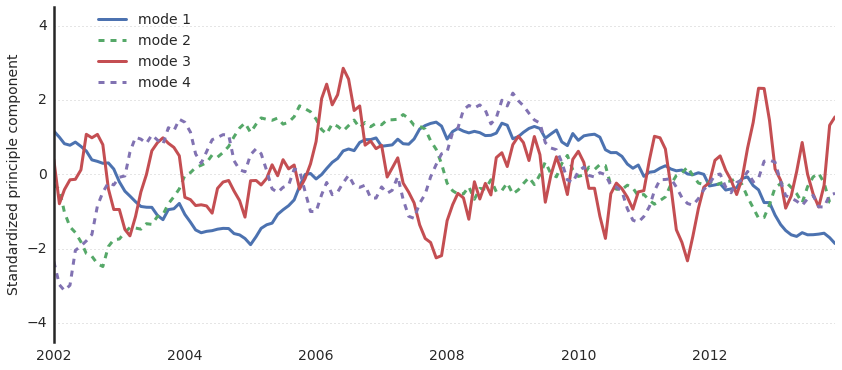

In [138]:
fig = plt.figure(figsize=(14, 6))
ax = fig.gca()
ax.grid(linestyle=':')
ax.yaxis.grid(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False) 
ax.spines["right"].set_visible(False)
ax.set_xlim([date_list[0], date_list[143]])
ax.set_ylim([-4.5, 4.5])
ax.set_ylabel('Standardized principle component', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[i.set_linewidth(2.5) for i in ax.spines.itervalues()] 
ax.tick_params(axis="both", which="both", bottom="off", top="off",    
            labelbottom="on", left="off", right="off", labelleft="on")

ax = fig.gca(); ax.grid()
ax.plot(date_list, PC[0, :], '-',  lw=3, label='mode 1')
ax.plot(date_list, PC[1, :], '--', lw=3, label='mode 2')
ax.plot(date_list, PC[2, :], '-',  lw=3, label='mode 3')
ax.plot(date_list, PC[3, :], '--', lw=3, label='mode 4')

LG = ax.legend(numpoints=1, bbox_to_anchor=(0.05, 1.0), loc=2, borderaxespad=0., prop={'size':14}); LG.draw_frame(False)

# Other measurements

## Velocity

In [20]:
MAT = scipy.io.loadmat('../../_data/Mask files/velocity_driven_transport_mask.mat')
vdt_mask = MAT['mask_arctic'][:]
lon_mask = MAT['lon'][:]
lat_mask = MAT['lat'][:]

nav_lon=coordinate_obj.variables['nav_lon'][:]
nav_lat=coordinate_obj.variables['nav_lat'][:]

mask_interp = reporj_NEMOgrid(lon_mask, lat_mask, vdt_mask, nav_lon, nav_lat, method='nearest')
mask_range = reporj_NEMOgrid(lon_mask, lat_mask, vdt_mask, nav_lon, nav_lat, method='linear')
mask_interp[np.isnan(mask_range)] = np.nan
mask_plot = np.ma.masked_where(np.isnan(mask_interp), mask_interp)

In [21]:
MAT = scipy.io.loadmat('../../_data/Exchange/UV_current.mat')
vozocrtx0 = MAT['vozocrtx0'][:]
vozocrtx1 = MAT['vozocrtx1'][:]
vomecrty0 = MAT['vomecrty0'][:]
vomecrty1 = MAT['vomecrty1'][:]

In [22]:
#vdt_ns = vomecrty0[:, mask_interp==2]
#vdt_ns[vdt_ns>0] = np.nan
#vdt = np.abs(np.nanmean(vdt_ns, 1))

## Intensity of transpolar drift

In [23]:
u_tpd = vozocrtx0[:, mask_interp==2]
v_tpd = vomecrty0[:, mask_interp==2]
vdt = np.abs(np.nanmean(np.sqrt(u_tpd*u_tpd+v_tpd*v_tpd), 1))

## Sea level height & BG intensity

In [26]:
H_FName = '/ocean/yingkai/GEOTRACES/FORCING/ANHA4/sossheig_monmean.nc'
h_obj = nc.Dataset(H_FName)
SSH = h_obj.variables['sossheig'][:, :, :]

In [27]:
SSH_BG = np.nanmax(SSH[:, mask_interp==1], 1) + 0.4

## SLP & AO index

In [28]:
year = np.arange(2002, 2014)
#u10 = np.empty([144, 368, 801])
#v10 = np.empty([144, 368, 801])
slp = np.empty([144, 368, 801])
for i in range(12):
#    name_u = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*u*'+str(year[i])+'*monmean*')
#    name_v = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*v*'+str(year[i])+'*monmean*')
    name_slp = glob.glob('/ocean/yingkai/GEOTRACES/FORCING/ANHA4/GDPS/*slp*'+str(year[i])+'*monmean*')
#    u_obj = nc.Dataset(name_u[0])
#    v_obj = nc.Dataset(name_v[0])
    slp_obj = nc.Dataset(name_slp[0])
#    u10[i*12:(i+1)*12, :, :] = u_obj.variables['u_wind'][:, :, :]
#    v10[i*12:(i+1)*12, :, :] = v_obj.variables['v_wind'][:, :, :]
    slp[i*12:(i+1)*12, :, :] = slp_obj.variables['atmpres'][:, :, :]

In [211]:
x = slp_obj.variables['LON'][:]
y = slp_obj.variables['LAT'][:]
[lon_slp, lat_slp] = np.meshgrid(x, y)

In [29]:
MAT = scipy.io.loadmat('../../_data/Exchange/AO_inds.mat')
AO = MAT['AO_index']

## Fresh water content

In [164]:
FWC_name = sorted(glob.glob('../../_data/MAT files/FWC/FWC_ANHA4_*.mat'))

In [166]:
FWC_name = sorted(glob.glob('../../_data/MAT files/FWC/FWC_ANHA4_*.mat'))
FWC = np.zeros([144, 800, 544])

for i in range(144):
    MAT = scipy.io.loadmat(FWC_name[i])
    FWC[i, :, :] = MAT['FWC'][:]

In [255]:
FWC[np.isnan(FWC)] = 0
FWC = detrend(FWC, 0)

# Explainations

## First Mode (19%)

* Strong Beaufort Gyre
* Strong Transpolar Drift, Good positive correlation with TPD intensity (0.476) 
* Divergence in Makarov Basin
* CAA ocean flows westward (to Beaufort Sea)

### Statistical relation with transpolar drift

In [30]:
pearsonr(PC[0, :], vdt)

(0.47632457101257147, 1.5948434367459017e-09)

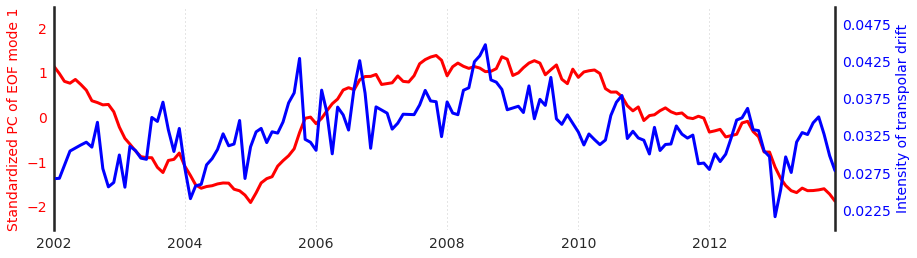

In [159]:
fig = plt.figure(figsize=(14, 4))
ax = fig.gca(); ax.grid()
ax2 = ax.twinx()

ax.grid(linestyle=':')
ax.yaxis.grid(False)
ax.set_ylim([-2.5, 2.5])
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False) 
ax.set_xlim([date_list[0], date_list[143]])
ax.set_ylabel('Standardized PC of EOF mode 1', fontsize=14, color='r')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[i.set_linewidth(2.5) for i in ax.spines.itervalues()] 
ax.tick_params(axis="both", which="both", bottom="off", top="off",    
            labelbottom="on", left="off", right="off", labelleft="on")
for tl in ax.get_yticklabels():
    tl.set_color('r')

ax2.set_ylim([0.02, 0.05])
ax2.set_yticks(np.arange(0.0225, 0.0525, 0.005))
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_ylabel('Intensity of transpolar drift', fontsize=14, color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    


ax.plot(date_list, PC[0, :], 'r', lw=3, label='PC of the EOF 1st mode')
ax2.plot(date_list, vdt, 'b', lw=3, label='Intensity of transpolar drift')


### Anomaly composition (based on PC) of ocean flow & FW content

In [272]:
thres = 1
u_pc0_p = np.nanmean(vozocrtx0[PC[0, :]>thres, :, :], 0)
v_pc0_p = np.nanmean(vomecrty0[PC[0, :]>thres, :, :], 0)
Ba_pc0_p = np.nanmean(Ba[PC[0, :]>thres, :, :], 0) 
FWC_pc0_p = np.nanmean(FWC[PC[0, :]>thres, :, :], 0) 
SLP_pc0_p = np.nanmean(slp[PC[0, :]>thres, :, :], 0) 

u_pc0_n = np.nanmean(vozocrtx0[PC[0, :]<-thres, :, :], 0)
v_pc0_n = np.nanmean(vomecrty0[PC[0, :]<-thres, :, :], 0)
Ba_pc0_n = np.nanmean(Ba[PC[0, :]<-thres, :, :], 0) 
FWC_pc0_n = np.nanmean(FWC[PC[0, :]<-thres, :, :], 0)
SLP_pc0_n = np.nanmean(slp[PC[0, :]<-thres, :, :], 0) 

u = u_pc0_p - u_pc0_n
v = v_pc0_p - v_pc0_n
dFWC = FWC_pc0_p - FWC_pc0_n
dBa = Ba_pc0_p - Ba_pc0_n
dSLP = (SLP_pc0_p - SLP_pc0_n)/100.0
#uT = Ba_pc0_p*u_pc0_p - Ba_pc0_n*u_pc0_n
#vT = Ba_pc0_p*v_pc0_p - Ba_pc0_n*v_pc0_n

In [273]:
lev_dT = np.array([-11, -9, -7, -5, -3, -1, 1, 3, 5, 7, 9, 11])/5.0

In [274]:
#dux, _ = Ats.central_diff(uT)
#_, dvy = Ats.central_diff(vT)
#divh = dux/e1t + dvy/e2t + vT*np.tan(nav_lat*np.pi/180.0)/6.3781e6;

In [275]:
##from scipy.interpolate import griddata
#xi, yi = np.meshgrid(np.linspace(-180, 180, 360), np.linspace(60, 90, 90))
#ui = Nts.reporj_NEMOgrid(nav_lon, nav_lat, u, xi, yi, method='nearest')
#vi = Nts.reporj_NEMOgrid(nav_lon, nav_lat, v, xi, yi, method='nearest')

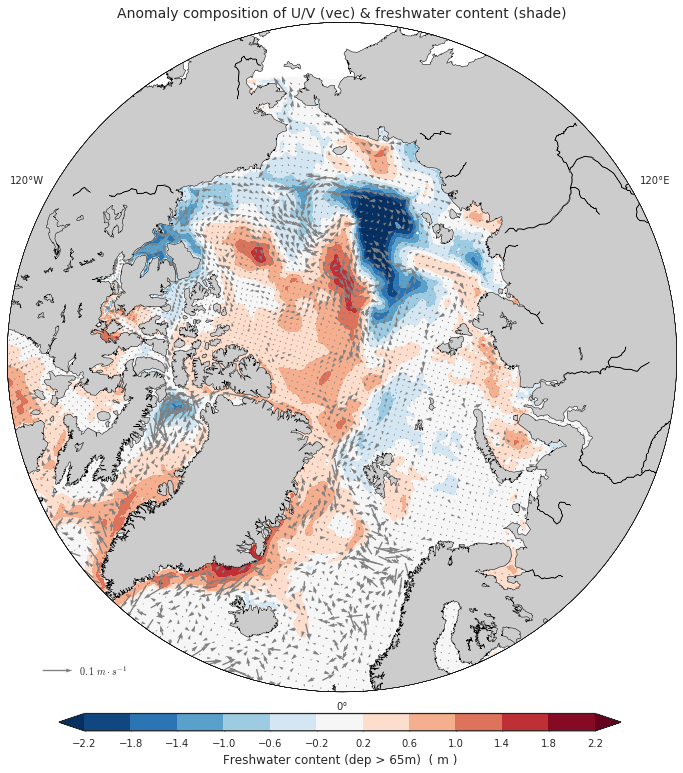

In [276]:
n = 5
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
#proj = Basemap(llcrnrlon=-180, llcrnrlat=60., urcrnrlon=180, urcrnrlat=90,
#              projection='lcc', lat_1=45, lat_2=75., lat_0=60, lon_0=0.)
proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')
x, y = proj(nav_lon, nav_lat)
CS = proj.contourf(x, y, dFWC, lev_dT, cmap = plt.cm.RdBu_r, extend='both')
Q = proj.quiver(x[::n, ::n], y[::n, ::n], u[::n, ::n], v[::n, ::n], width=0.002, headwidth=3, scale=2.25, color='gray')

qk = plt.quiverkey(Q, 0.2, 0.15, 0.1, r'$0.1\ m\cdot s^{-1}$',
                   labelpos='E',
                   coordinates='figure',
                   fontproperties={'weight': 'bold'})

cax  = fig.add_axes([0.185, 0.08, 0.65, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Freshwater content (dep > 65m)  ( m )', fontsize=12)
CBar.ax.tick_params(axis='x', length=15, direction='in')
CBar.set_ticks(lev_dT)

ax.set_title('Anomaly composition of U/V (vec) & freshwater content (shade)', fontsize=14)


### Anomaly composition of SLP

In [277]:
lev_dSLP = np.array([-9, -7, -5, -3, -1, 1, 3, 5, 7, 9])/3.0

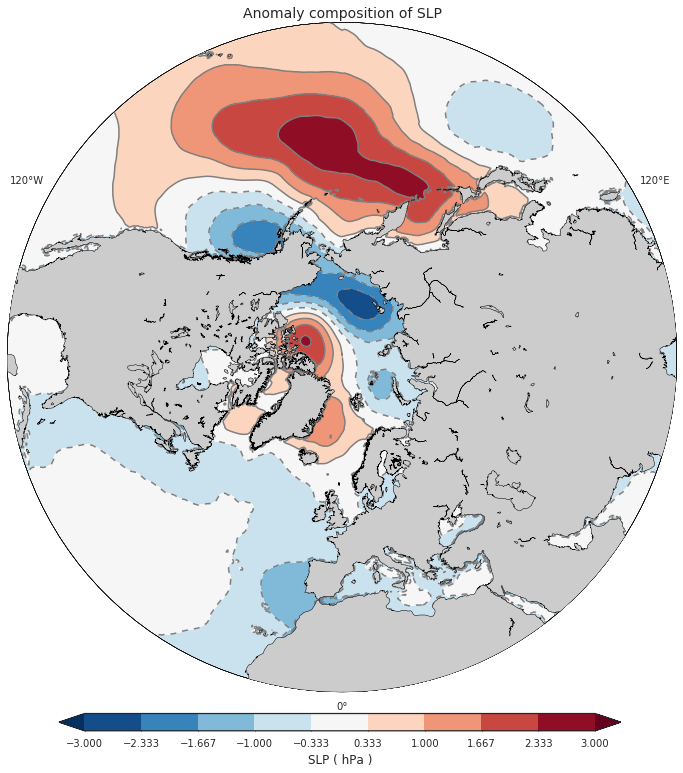

In [278]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=20, lon_0=0, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='0.8', lake_color=None, zorder=2)
proj.drawcoastlines(linewidth=0.5, color='k', zorder=3)
x, y = proj(lon_slp, lat_slp)
CS = proj.contourf(x, y, dSLP, lev_dSLP, cmap = plt.cm.RdBu_r, extend='both')
proj.contour(x, y, dSLP, lev_dSLP, colors=('gray',), linewidths=1.5)

ax.set_title('Anomaly composition of SLP', fontsize=14)

cax  = fig.add_axes([0.185, 0.08, 0.65, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('SLP ( hPa )', fontsize=12)
CBar.ax.tick_params(axis='x', length=15, direction='in')
CBar.set_ticks(lev_dSLP)

## Second Mode (14%)

* Beaufort Gyre shifts westward (heading Mendeleyev ridge)
* Strong Northward currents with low Bad in Fram Strait
* CAA ocean flows eastward (to Baffin Bay) through Lancaste Sound, but not too much through Near Strait

In [279]:
pearsonr(PC[1, :], vdt)

(0.28334818905758358, 0.00057881971063921474)

In [280]:
thres = 1
u_pc1_p = np.nanmean(vozocrtx0[PC[1, :]>thres, :, :], 0)
v_pc1_p = np.nanmean(vomecrty0[PC[1, :]>thres, :, :], 0)
Ba_pc1_p = np.nanmean(Ba[PC[1, :]>thres, :, :], 0) 
FWC_pc1_p = np.nanmean(FWC[PC[1, :]>thres, :, :], 0) 
SLP_pc1_p = np.nanmean(slp[PC[1, :]>thres, :, :], 0) 

u_pc1_n = np.nanmean(vozocrtx0[PC[1, :]<-thres, :, :], 0)
v_pc1_n = np.nanmean(vomecrty0[PC[1, :]<-thres, :, :], 0)
Ba_pc1_n = np.nanmean(Ba[PC[1, :]<-thres, :, :], 0) 
FWC_pc1_n = np.nanmean(FWC[PC[1, :]<-thres, :, :], 0)
SLP_pc1_n = np.nanmean(slp[PC[1, :]<-thres, :, :], 0) 

u = u_pc1_p - u_pc1_n
v = v_pc1_p - v_pc1_n
dFWC = FWC_pc1_p - FWC_pc1_n
dBa = Ba_pc1_p - Ba_pc1_n
dSLP = (SLP_pc1_p - SLP_pc1_n)/100.0

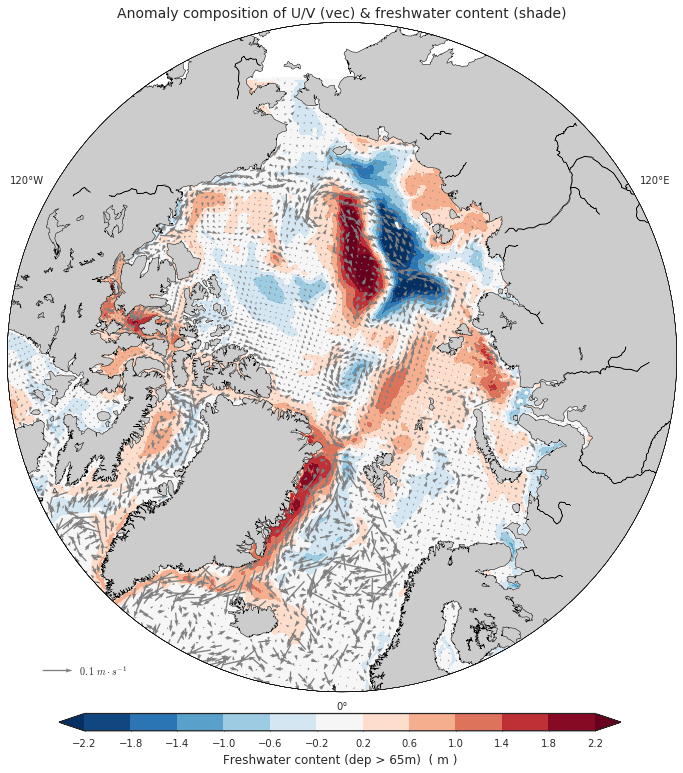

In [281]:
n = 5
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
#proj = Basemap(llcrnrlon=-180, llcrnrlat=60., urcrnrlon=180, urcrnrlat=90,
#              projection='lcc', lat_1=45, lat_2=75., lat_0=60, lon_0=0.)
proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')
x, y = proj(nav_lon, nav_lat)
CS = proj.contourf(x, y, dFWC, lev_dT, cmap = plt.cm.RdBu_r, extend='both')
Q = proj.quiver(x[::n, ::n], y[::n, ::n], u[::n, ::n], v[::n, ::n], width=0.002, headwidth=3, scale=2.25, color='gray')

qk = plt.quiverkey(Q, 0.2, 0.15, 0.1, r'$0.1\ m\cdot s^{-1}$',
                   labelpos='E',
                   coordinates='figure',
                   fontproperties={'weight': 'bold'})

cax  = fig.add_axes([0.185, 0.08, 0.65, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Freshwater content (dep > 65m)  ( m )', fontsize=12)
CBar.ax.tick_params(axis='x', length=15, direction='in')
CBar.set_ticks(lev_dT)

ax.set_title('Anomaly composition of U/V (vec) & freshwater content (shade)', fontsize=14)


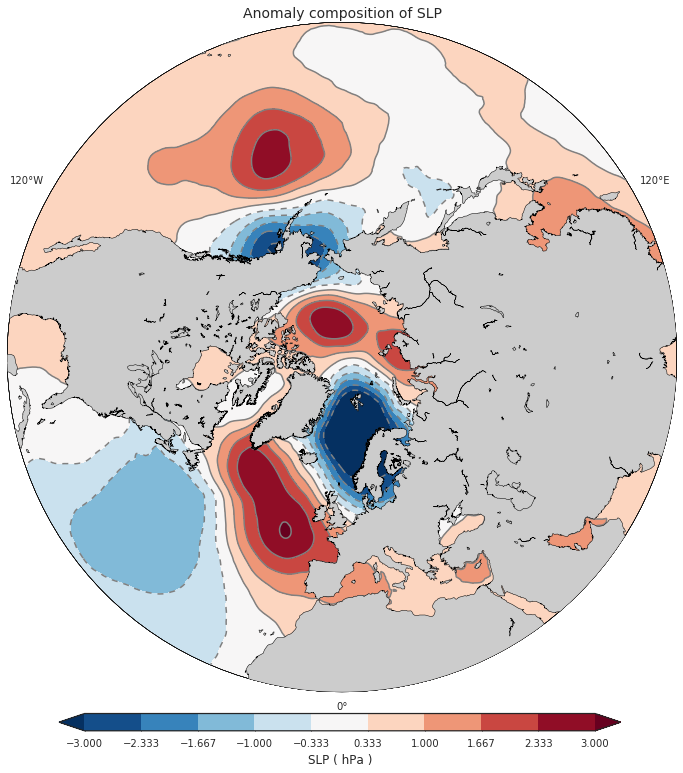

In [282]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=20, lon_0=0, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='0.8', lake_color=None, zorder=2)
proj.drawcoastlines(linewidth=0.5, color='k', zorder=3)
x, y = proj(lon_slp, lat_slp)
CS = proj.contourf(x, y, dSLP, lev_dSLP, cmap = plt.cm.RdBu_r, extend='both')
proj.contour(x, y, dSLP, lev_dSLP, colors=('gray',), linewidths=1.5)

ax.set_title('Anomaly composition of SLP', fontsize=14)

cax  = fig.add_axes([0.185, 0.08, 0.65, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('SLP ( hPa )', fontsize=12)
CBar.ax.tick_params(axis='x', length=15, direction='in')
CBar.set_ticks(lev_dSLP)

## Third Mode (11%)

* Weak Beaufort Gyre
* Anti-cyclonic flow in CAA, convergence in the estuary of Mackenzie
* Ocean flow from Euraisa continetal shelf to Beaufort Sea

In [283]:
thres = 1
u_pc2_p = np.nanmean(vozocrtx0[PC[2, :]>thres, :, :], 0)
v_pc2_p = np.nanmean(vomecrty0[PC[2, :]>thres, :, :], 0)
Ba_pc2_p = np.nanmean(Ba[PC[2, :]>thres, :, :], 0) 
FWC_pc2_p = np.nanmean(FWC[PC[2, :]>thres, :, :], 0) 
SLP_pc2_p = np.nanmean(slp[PC[2, :]>thres, :, :], 0) 

u_pc2_n = np.nanmean(vozocrtx0[PC[2, :]<-thres, :, :], 0)
v_pc2_n = np.nanmean(vomecrty0[PC[2, :]<-thres, :, :], 0)
Ba_pc2_n = np.nanmean(Ba[PC[2, :]<-thres, :, :], 0) 
FWC_pc2_n = np.nanmean(FWC[PC[2, :]<-thres, :, :], 0)
SLP_pc2_n = np.nanmean(slp[PC[2, :]<-thres, :, :], 0) 

u = u_pc2_p - u_pc2_n
v = v_pc2_p - v_pc2_n
dFWC = FWC_pc2_p - FWC_pc2_n
dBa = Ba_pc2_p - Ba_pc2_n
dSLP = (SLP_pc2_p - SLP_pc2_n)/100.0

In [284]:
pearsonr(PC[2, :], SSH_BG[:])

(-0.66113220458515409, 1.91333098766595e-19)

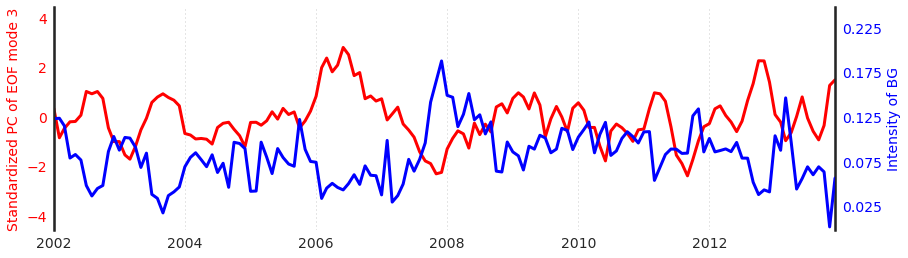

In [285]:
fig = plt.figure(figsize=(14, 4))
ax = fig.gca(); ax.grid()
ax2 = ax.twinx()

ax.grid(linestyle=':')
ax.yaxis.grid(False)
ax.set_ylim([-4.5, 4.5])
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False) 
ax.set_xlim([date_list[0], date_list[143]])
ax.set_ylabel('Standardized PC of EOF mode 3', fontsize=14, color='r')
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
[i.set_linewidth(2.5) for i in ax.spines.itervalues()] 
ax.tick_params(axis="both", which="both", bottom="off", top="off",    
            labelbottom="on", left="off", right="off", labelleft="on")
for tl in ax.get_yticklabels():
    tl.set_color('r')

ax2.set_ylim([0, 0.25])
ax2.set_yticks(np.arange(0.025, 0.275, 0.05))
ax2.spines["top"].set_visible(False)
ax2.spines["bottom"].set_visible(False)
ax2.yaxis.set_tick_params(labelsize=14)
ax2.set_ylabel('Intensity of BG', fontsize=14, color='b')
for tl in ax2.get_yticklabels():
    tl.set_color('b')
    


ax.plot(date_list, PC[2, :], 'r', lw=3, label='PC of the EOF 3rd mode')
ax2.plot(date_list, SSH_BG, 'b', lw=3, label='Intensity of transpolar drift')

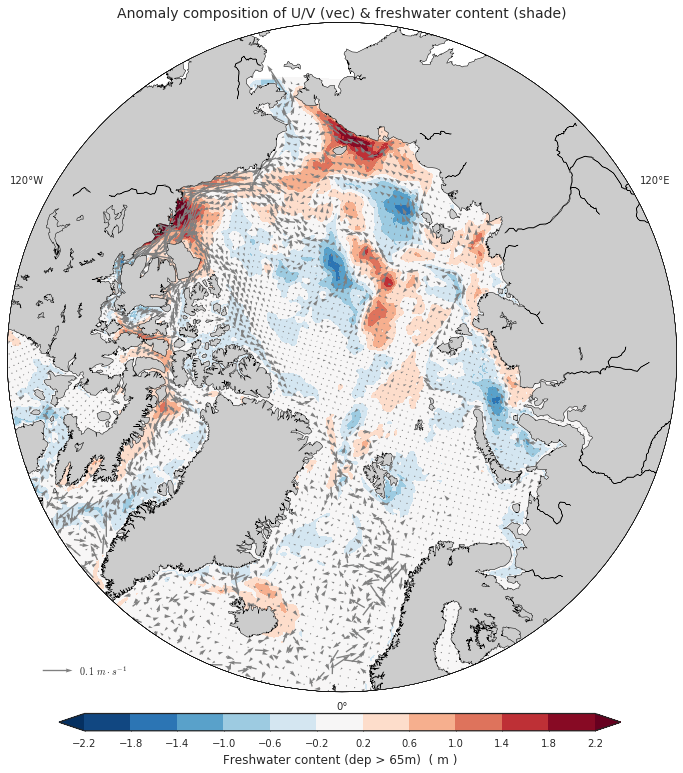

In [286]:
n = 5
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
#proj = Basemap(llcrnrlon=-180, llcrnrlat=60., urcrnrlon=180, urcrnrlat=90,
#              projection='lcc', lat_1=45, lat_2=75., lat_0=60, lon_0=0.)
proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')
x, y = proj(nav_lon, nav_lat)
CS = proj.contourf(x, y, dFWC, lev_dT, cmap = plt.cm.RdBu_r, extend='both')
Q = proj.quiver(x[::n, ::n], y[::n, ::n], u[::n, ::n], v[::n, ::n], width=0.002, headwidth=3, scale=2.25, color='gray')

qk = plt.quiverkey(Q, 0.2, 0.15, 0.1, r'$0.1\ m\cdot s^{-1}$',
                   labelpos='E',
                   coordinates='figure',
                   fontproperties={'weight': 'bold'})

cax  = fig.add_axes([0.185, 0.08, 0.65, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Freshwater content (dep > 65m)  ( m )', fontsize=12)
CBar.ax.tick_params(axis='x', length=15, direction='in')
CBar.set_ticks(lev_dT)

ax.set_title('Anomaly composition of U/V (vec) & freshwater content (shade)', fontsize=14)


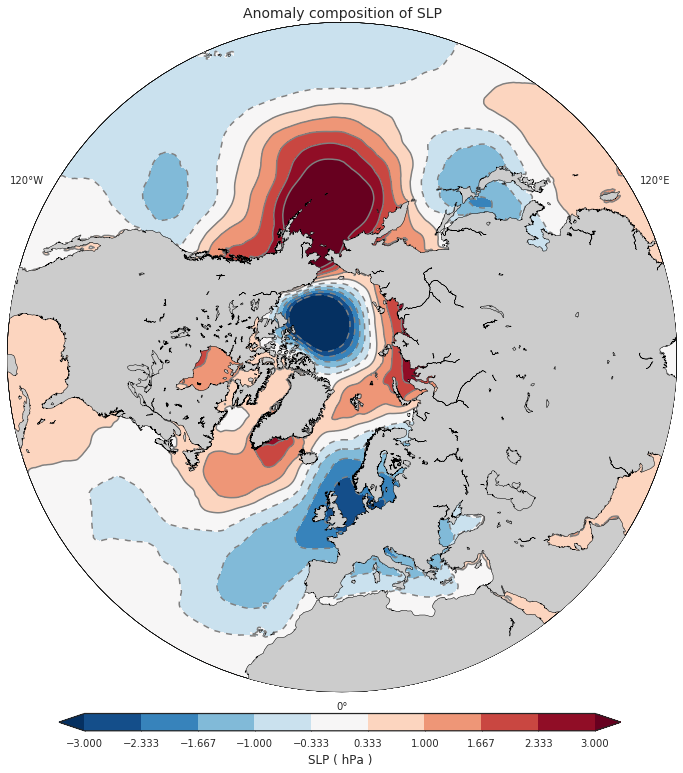

In [287]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=20, lon_0=0, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='0.8', lake_color=None, zorder=2)
proj.drawcoastlines(linewidth=0.5, color='k', zorder=3)
x, y = proj(lon_slp, lat_slp)
CS = proj.contourf(x, y, dSLP, lev_dSLP, cmap = plt.cm.RdBu_r, extend='both')
proj.contour(x, y, dSLP, lev_dSLP, colors=('gray',), linewidths=1.5)

ax.set_title('Anomaly composition of SLP', fontsize=14)

cax  = fig.add_axes([0.185, 0.08, 0.65, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('SLP ( hPa )', fontsize=12)
CBar.ax.tick_params(axis='x', length=15, direction='in')
CBar.set_ticks(lev_dSLP)

# Fourth mode (7%)

In [288]:
thres = 1
u_pc3_p = np.nanmean(vozocrtx0[PC[3, :]>thres, :, :], 0)
v_pc3_p = np.nanmean(vomecrty0[PC[3, :]>thres, :, :], 0)
Ba_pc3_p = np.nanmean(Ba[PC[3, :]>thres, :, :], 0) 
FWC_pc3_p = np.nanmean(FWC[PC[3, :]>thres, :, :], 0) 
SLP_pc3_p = np.nanmean(slp[PC[3, :]>thres, :, :], 0) 

u_pc3_n = np.nanmean(vozocrtx0[PC[3, :]<-thres, :, :], 0)
v_pc3_n = np.nanmean(vomecrty0[PC[3, :]<-thres, :, :], 0)
Ba_pc3_n = np.nanmean(Ba[PC[3, :]<-thres, :, :], 0) 
FWC_pc3_n = np.nanmean(FWC[PC[3, :]<-thres, :, :], 0)
SLP_pc3_n = np.nanmean(slp[PC[3, :]<-thres, :, :], 0) 

u = u_pc3_p - u_pc3_n
v = v_pc3_p - v_pc3_n
dFWC = FWC_pc3_p - FWC_pc3_n
dBa = Ba_pc3_p - Ba_pc3_n
dSLP = (SLP_pc3_p - SLP_pc3_n)/100.0

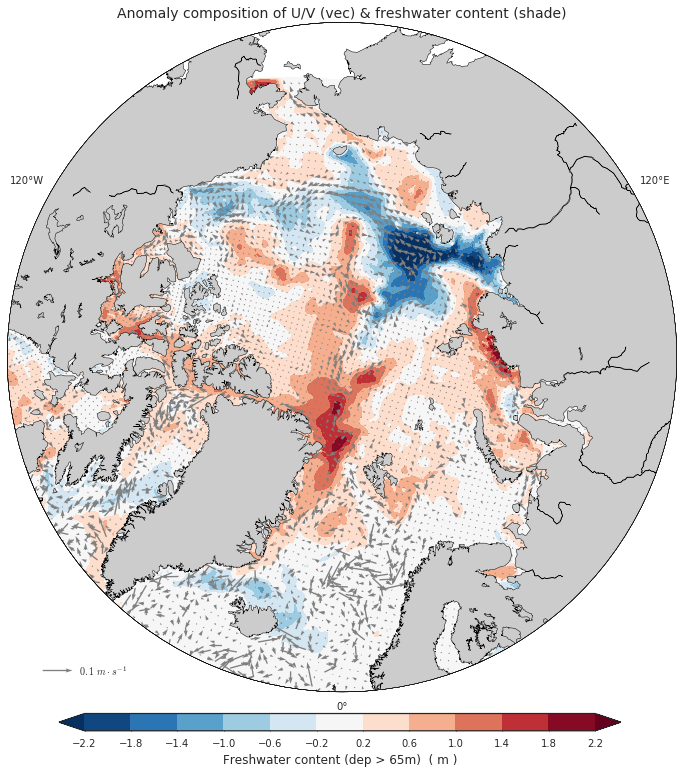

In [289]:
n = 5
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=60, lon_0=0, round=True, ax=ax)
#proj = Basemap(llcrnrlon=-180, llcrnrlat=60., urcrnrlon=180, urcrnrlat=90,
#              projection='lcc', lat_1=45, lat_2=75., lat_0=60, lon_0=0.)
proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='0.8', lake_color=None)
proj.drawcoastlines(linewidth=0.5, color='k')
x, y = proj(nav_lon, nav_lat)
CS = proj.contourf(x, y, dFWC, lev_dT, cmap = plt.cm.RdBu_r, extend='both')
Q = proj.quiver(x[::n, ::n], y[::n, ::n], u[::n, ::n], v[::n, ::n], width=0.002, headwidth=3, scale=2.25, color='gray')

qk = plt.quiverkey(Q, 0.2, 0.15, 0.1, r'$0.1\ m\cdot s^{-1}$',
                   labelpos='E',
                   coordinates='figure',
                   fontproperties={'weight': 'bold'})

cax  = fig.add_axes([0.185, 0.08, 0.65, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('Freshwater content (dep > 65m)  ( m )', fontsize=12)
CBar.ax.tick_params(axis='x', length=15, direction='in')
CBar.set_ticks(lev_dT)

ax.set_title('Anomaly composition of U/V (vec) & freshwater content (shade)', fontsize=14)


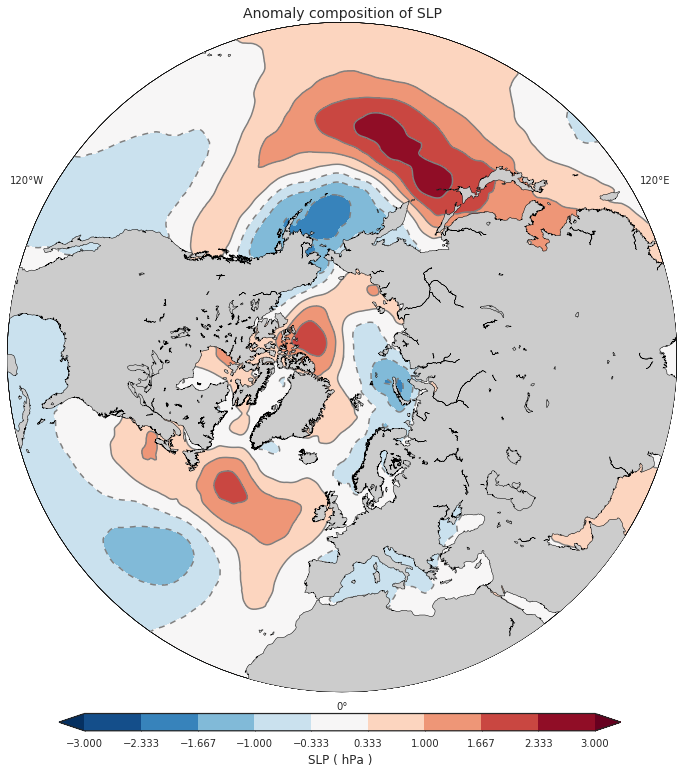

In [290]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
proj=Basemap(projection='npstere', resolution='l', boundinglat=20, lon_0=0, round=True, ax=ax)
proj.drawmeridians(np.arange(0, 360, 120), labels=[1, 1, 1, 1], fontsize=10, latmax=90,linewidth=0)
proj.fillcontinents(color='0.8', lake_color=None, zorder=2)
proj.drawcoastlines(linewidth=0.5, color='k', zorder=3)
x, y = proj(lon_slp, lat_slp)
CS = proj.contourf(x, y, dSLP, lev_dSLP, cmap = plt.cm.RdBu_r, extend='both')
proj.contour(x, y, dSLP, lev_dSLP, colors=('gray',), linewidths=1.5)

ax.set_title('Anomaly composition of SLP', fontsize=14)

cax  = fig.add_axes([0.185, 0.08, 0.65, 0.02])
CBar = fig.colorbar(CS, cax=cax, orientation='horizontal')
CBar.set_label('SLP ( hPa )', fontsize=12)
CBar.ax.tick_params(axis='x', length=15, direction='in')
CBar.set_ticks(lev_dSLP)

In [556]:
#proj = ccrs.PlateCarree()
#proj = ccrs.RotatedPole(pole_longitude=180, pole_latitude=90)

In [557]:
#n = 1
#fig = plt.figure(figsize=(10, 10))
#ax = fig.gca(projection=ccrs.NorthPolarStereo(central_longitude=0))
#ax.set_extent([-180, 180, 60, 90], ccrs.PlateCarree())
#ax.add_feature(cartopy.feature.OCEAN, zorder=0)
#ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
#ax.gridlines()
#ax.streamplot(xi[::n, ::n], yi[::n, ::n], -ui[::n, ::n], -vi[::n, ::n], transform=proj)
##ax.plot(-5, 70, 'ro', transform=proj)